In [1]:
### Importing modules

import numpy as np
from ipywidgets import Layout, interact, fixed
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import sys
from scipy import ndimage
from scipy.ndimage import gaussian_filter1d as gf1d
from skimage import measure
%matplotlib notebook
import matplotlib
from matplotlib import pylab
import skimage
from skimage import filters
#from skimage.filters import threshold_adaptive
from skimage import feature
from matplotlib import cm
from matplotlib.pyplot import figure
from skimage.filters import roberts, sobel, sobel_h, sobel_v, scharr, \
    scharr_h, scharr_v, prewitt, prewitt_v, prewitt_h
import tiff_file

C:\Users\RMCGORTY\Documents\GitHub\Capsule_Formation\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
C:\Users\RMCGORTY\Documents\GitHub\Capsule_Formation\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
C:\Users\RMCGORTY\Documents\GitHub\Capsule_Formation\tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


# Here, we'll find the droplet's size and position and then use PIV to see how it is expanding/contracting and how fluid/solid it is

### First, we'll read in the data

In [3]:
# Specify the directory where the data is
data_directory = "Z:\\StevenD_Spring2020\\Data\\2021-03-11\\"

In [4]:
#Specify the file name
data_file = "Image01 RR0103112021_Substack.tif"
#data_file = "11_40XS_60X_DIC_PFS_StackReg_Shrink.tif"

In [5]:
#Read in the image file
im=tiff_file.imread(data_directory+data_file)

C:\Users\RMCGORTY\Documents\GitHub\Capsule_Formation\tiff_file.py:724: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.vstack((p.asarray() if p else nopage)


In [6]:
print("Shape of the image data file: (%i,%i,%i)" % im.shape)
print("So each image is %i-by-%i pixels large and we have %i frames in our movie." % (im.shape[1], im.shape[2], im.shape[0]))

Shape of the image data file: (754,460,511)
So each image is 460-by-511 pixels large and we have 754 frames in our movie.


### Optimizing parameters

Here, we are finding the parameters necessary to locate the droplet. That is, for any pixel in the image, we want to know if that pixel is *within* or *outside* the droplet. 

<IPython.core.display.Javascript object>


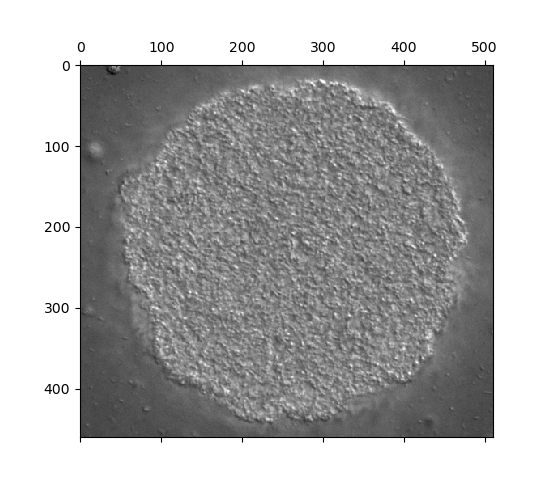

In [7]:
# Just to check things out, take a look at one of the images

%matplotlib notebook

##############################################################
# CHOOSE A FRAME TO LOOK AT.
# You should open the movie in ImageJ. Find a frame where
# the droplet is shrinking and somewhat gelled.
##############################################################
image_number = 700 #this is the frame number we'll look at


plt.matshow(im[image_number], cmap=plt.cm.gray)

Next, we try filtering the image.

Before you go further, you should check out [this tutorial on image processing](http://scipy-lectures.org/advanced/image_processing/). In particular, pay close attention to the sections on image filtering and feature extraction. 

<IPython.core.display.Javascript object>


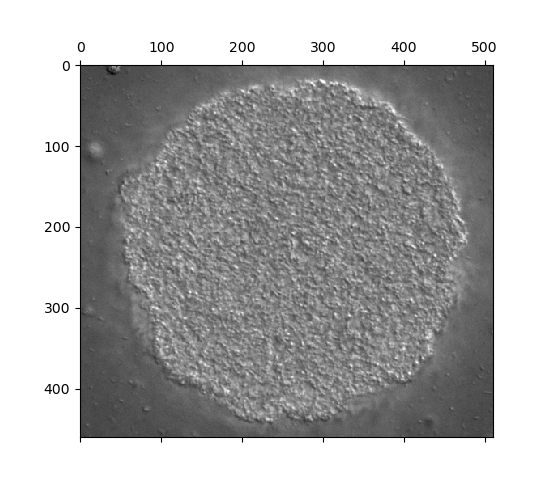

<IPython.core.display.Javascript object>


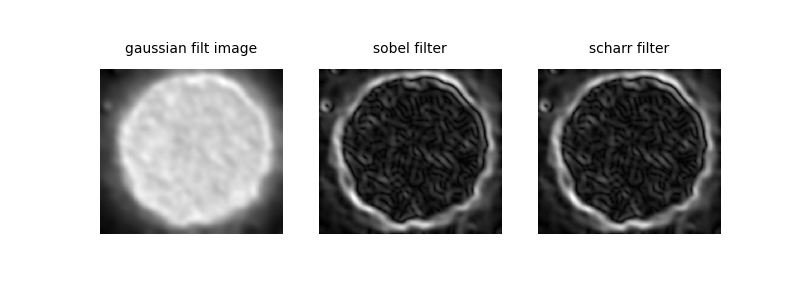

Text(0.5, 1.05, 'scharr filter')

In [11]:
#Let's make a copy of one of the frames so we can test some things out
image = im[image_number].copy()

#We'll show that image
plt.matshow(image, cmap=plt.cm.gray)

#Now, try filtering the images
#  We try: a Gaussian filter
#  And then, on top of that: a Sobel filter and a Scharr filter
gaussian_filter_size = 9  # <--- you might vary this if necessary
filter_image_gauss = ndimage.gaussian_filter(image, gaussian_filter_size)
filter_image_sobel = sobel(filter_image_gauss)
filter_image_scharr = scharr(filter_image_gauss)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.matshow(filter_image_gauss, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('gaussian filt image', fontsize=10)

ax2.matshow(filter_image_sobel, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('sobel filter', fontsize=10)

ax3.matshow(filter_image_scharr, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('scharr filter', fontsize=10)

What we want to do is to locate the boundaries of our droplet. <br>
Let's stick with the Sobel filter and work more with that. 

<IPython.core.display.Javascript object>


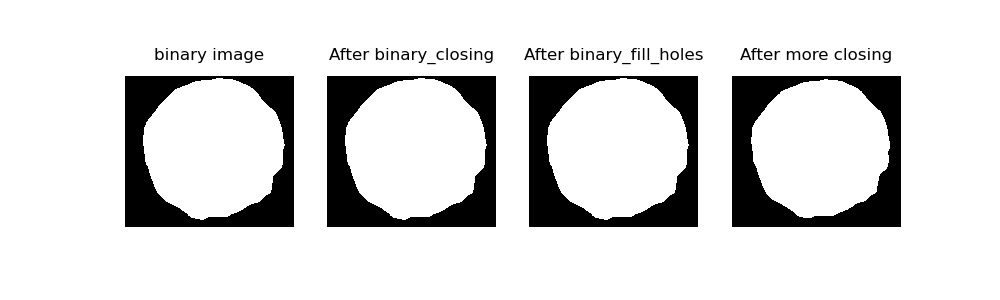

In [10]:
fig,ax = plt.subplots(1,4,figsize=(10,3))

######################################################################################
# Parameters you should adjust! Play around with these and see what effect they have.
#    blackwhite_threshold_fraction -- set to 0.22
#    edge -- set to 50
#    interations_b_closing -- set to 26
#    interations_b_erosion -- set to 10
#
# You can adjust these, see what effect it has on the filtered image and even run
#  through the rest of the code with your chosen parameters. If it doesn't work
#  out in the end, you can change back to the values listed above.
# You might also want to change the image number (that is, the frame) and see if 
#  it still works. You want a set of parameters that turns any of the images of the
#  droplet in a movie to a binary image where pixels that are interior to the droplet
#  are set to 1, and all other pixels set to 0. 
#####################################################################################

### COMMENT OUT TWO OF THE THREE BELOW
FILTER_TO_USE = 'gaussian'
#FILTER_TO_USE = 'sobel'
#FILTER_TO_USE = 'scharr'


blackwhite_threshold_fraction = 0.90 #Our threshold will be 22% of the maximum value
if FILTER_TO_USE == 'gaussian':
    bw_threshold = blackwhite_threshold_fraction*filter_image_gauss.max()  
    bw_image = filter_image_gauss>bw_threshold #turn image into binary (black/white) image
if FILTER_TO_USE == 'sobel':
    bw_threshold = blackwhite_threshold_fraction*filter_image_sobel.max()  
    bw_image = filter_image_sobel>bw_threshold #turn image into binary (black/white) image
if FILTER_TO_USE == 'scharr':
    bw_threshold = blackwhite_threshold_fraction*filter_image_scharr.max()  
    bw_image = filter_image_scharr>bw_threshold #turn image into binary (black/white) image
ax[0].matshow(bw_image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title("binary image")

#Set the edge to zero (if bits of other droplets are shown at the edges, we want them gone)
edge = 1
value_to_replace = 0
bw_image[0:edge,:] = value_to_replace
bw_image[:,-edge:] = value_to_replace
bw_image[-edge:,:] = value_to_replace
bw_image[:,0:edge] = value_to_replace

#Use "binary closing". Number of "interations" can be adjusted
interations_b_closing = 1
bw_new = ndimage.morphology.binary_closing(bw_image,iterations=interations_b_closing)
ax[1].matshow(bw_new, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title("After binary_closing")

#Now use a 'fill_holes' operation
bw_new = ndimage.morphology.binary_fill_holes(bw_new)
ax[2].matshow(bw_new, cmap=plt.cm.gray)
ax[2].axis('off')
ax[2].set_title("After binary_fill_holes")

#Finally, use "binary erosion". Number of "interations" can be adjusted
interations_b_erosion = 4 
bw_new = ndimage.morphology.binary_erosion(bw_new,iterations=interations_b_erosion)
ax[3].matshow(bw_new, cmap=plt.cm.gray)
ax[3].axis('off')
ax[3].set_title("After more closing");

Based on the parameters you determine work best above, let's make a function that does all that. With this function, we can quickly process a series of images.

In [12]:
################################################################################################
# Parameters that you optimized above are use here. They can be used as the default values for
# the arguments to this 'generate_mask' function. 
###############################################################################################

def generate_mask(image, gf_filter_size=9, bw_thresh_fraction=0.90,interations_b_closing=1,interations_b_erosion=4,
                 radius_fraction1 = 0.9, radius_fraction2 = 0.9, filt='None'):
    '''
    The parameters of this function:
        image: the 2D image to analyze
        gf_filter_size: size parameter for Gaussian filtering of image 
        bw_thresh_fraction: threshold fraction for getting binary image after Sobel filter
        interations_b_closing: iterations of binary closing operation
        interations_b_erosion: iterations of binary erosion operation
        radius_fraction1:
        radius_fraction2:
        
       
    '''


    filter_image = ndimage.gaussian_filter(image,gf_filter_size)

    if filt=='None':
        filt1 = filter_image
    if filt=='sobel':
        filt1 = sobel(filter_image)
    
    bw_threshold = bw_thresh_fraction*filt1.max()
    bw_image = filt1>bw_threshold
    
    #Set the edge to zero (if bits of other droplets are shown at the edges, we want them gone)
    edge = 1
    value_to_replace = 0
    bw_image[0:edge,:] = value_to_replace
    bw_image[:,-edge:] = value_to_replace
    bw_image[-edge:,:] = value_to_replace
    bw_image[:,0:edge] = value_to_replace
    
    
    bw_new = ndimage.morphology.binary_closing(bw_image,iterations=interations_b_closing)

    bw_new = ndimage.morphology.binary_fill_holes(bw_new)

    bw_new = ndimage.morphology.binary_erosion(bw_new,iterations=interations_b_erosion)
    
    com = ndimage.center_of_mass(bw_new)
    radius = np.sqrt(bw_new.sum()/np.pi)
    
    xc = image.shape[0]/2
    yc = image.shape[1]/2

    ## this if-else checks if image is even or odd
    if im.shape[1] % 2:
        xx,yy = np.meshgrid(np.arange(-1*yc,yc+1,1)-com[1]+yc,np.arange(-1*xc,xc+1,1)-com[0]+xc)
    else:
        xx,yy = np.meshgrid(np.arange(-1*yc,yc,1)-com[1]+yc,np.arange(-1*xc,xc,1)-com[0]+xc)

    r = np.sqrt(xx**2 + yy**2)
    rmask = r<(radius_fraction1*radius) #was 0.85
    rmask2 = r<(radius_fraction2*radius)
    
    #distances = r - np.array([comx,comy])
    
    
    return bw_new, rmask, rmask2, radius, com


<IPython.core.display.Javascript object>


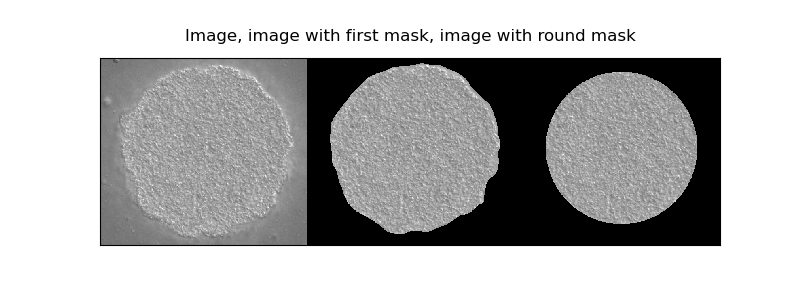

We found the radius of this droplet to be 208.2
We found the droplet's center of mass to be at 220,267


In [13]:
#Try out this function for different frames (just change the 'image_number')
image_number = 700

mask, rmask, rmask2, rad, com = generate_mask(im[image_number])

#Let's see the results
plt.figure(figsize=(8,3))
plt.matshow(np.c_[im[image_number], im[image_number]*mask, im[image_number]*rmask], cmap=cm.gray, fignum=False)
plt.xticks([]); plt.yticks([])
plt.title("Image, image with first mask, image with round mask")

print("We found the radius of this droplet to be %.1f" % rad)
print("We found the droplet's center of mass to be at %i,%i" % com)

In [14]:
################################################################################################
# Now we can do this for many frames of the movies. We'll just pick the ones where the 
# droplet is shrinking and expanding. So just before it starts to gel to right after it
# turns to a fluid. 
###############################################################################################

#enter in the start frame and the end frame here
start = 1
end = 750

#first we initialize some arrays, for storing data
im_matrix_new = im[start:end,:,:].copy()
just_mask = im[start:end,:,:].copy()
just_mask2 = im[start:end,:,:].copy()
radii = np.zeros((im_matrix_new.shape[0]))
centers_of_mass = np.zeros((im_matrix_new.shape[0],2))

#then, we'll look over the set of images (from frames `start' to `end')
for i in range(im_matrix_new.shape[0]):
    mask, rmask, rmask2, rad, com = generate_mask(im[start+i])
    im_matrix_new[i] = im[start+i]*rmask
    just_mask[i] = rmask
    just_mask2[i] = rmask2
    radii[i] = rad
    centers_of_mass[i] = com

In [15]:
print("Shape of 'im_matrix_new': ", im_matrix_new.shape)

Shape of 'im_matrix_new':  (749, 460, 511)


<IPython.core.display.Javascript object>


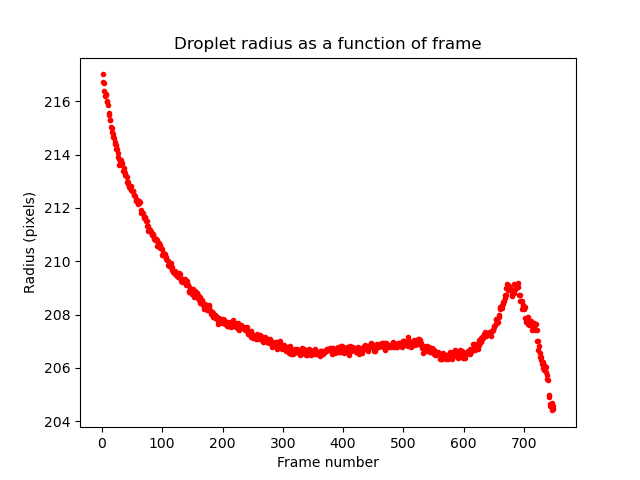

<IPython.core.display.Javascript object>


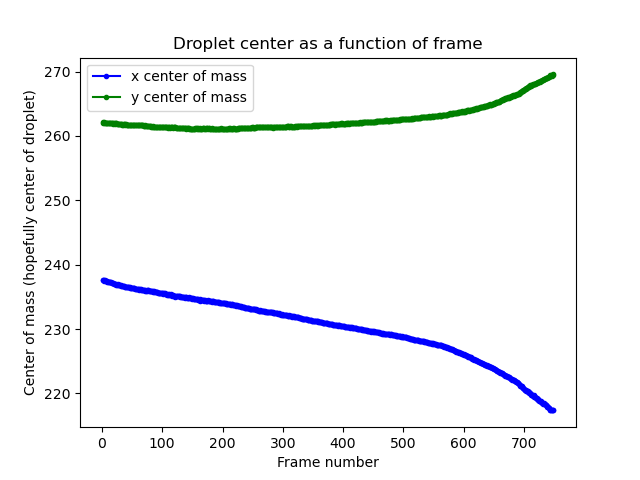

In [16]:
frames = np.arange(start,end)

plt.figure()
plt.plot(frames,radii,'r.')
plt.ylabel("Radius (pixels)")
plt.xlabel("Frame number")
plt.title('Droplet radius as a function of frame')

plt.figure()
plt.plot(frames,centers_of_mass[:,0],'-b.',label="x center of mass")
plt.plot(frames,centers_of_mass[:,1],'-g.',label="y center of mass")
plt.ylabel("Center of mass (hopefully center of droplet)")
plt.xlabel("Frame number")
plt.title("Droplet center as a function of frame")
plt.legend()

In [40]:
################################################################################################
# Run this to inspect how well the code did in finding the droplet. 
# After you run this, open up the generated tiff file (which should be in 
# the same directory this ipynb file is in)
###############################################################################################

## THIS WILL SAVE THE PROCESSED MOVIE IN YOUR CODE DIRECTORY!
tiff_file.imsave(data_file[:-4]+"_test.tif", im_matrix_new)

## Now to doing PIV work

You will likely need to install the Python package [numdifftools](https://numdifftools.readthedocs.io/en/latest/tutorials/install.html) for this to work. Check out that link for installation instructions. <br>

Most likely, all you will need to do is open up an Anaconda Prompt. Then just type: <br>
> `pip install numdifftools`
<br>

<br>You'll also need to install the Python package [openpiv](https://github.com/OpenPIV/openpiv-python). To install, you'll again open up an Anaconda Prompt and type: <br>
> `conda install -c conda-forge openpiv`

In [18]:
import numdifftools as nd
from openpiv import tools, scaling, pyprocess, validation, filters

In [19]:
from openpiv import piv

<IPython.core.display.Javascript object>


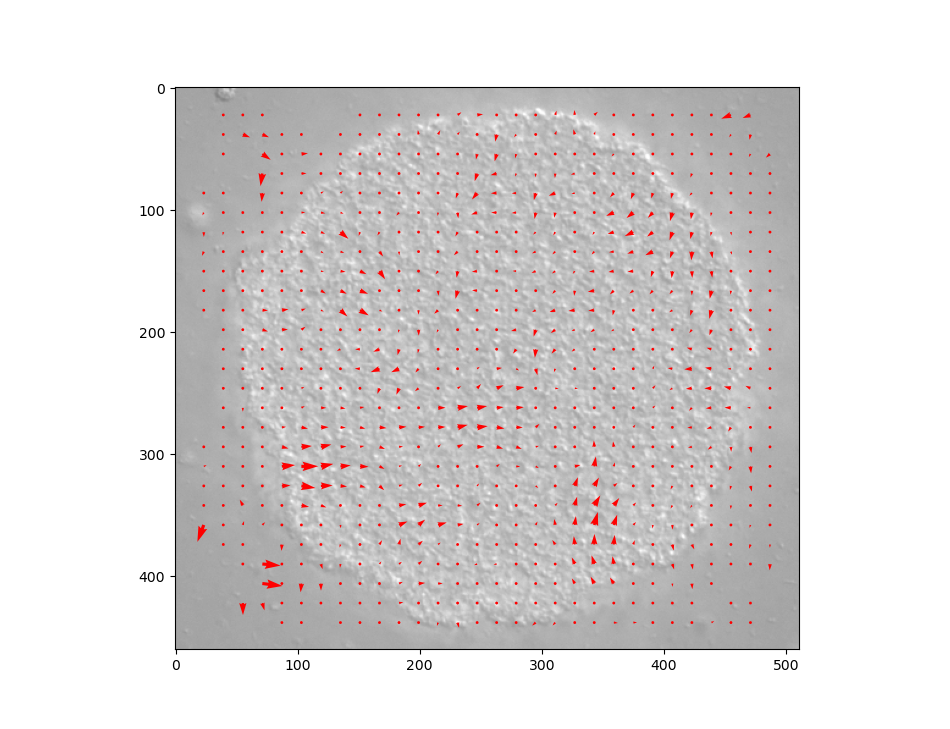

(27, 30)
(27, 30)
(27, 30)
(27, 30)


In [20]:
x,y,u,v = piv.simple_piv(im[700],im[710])
print(x.shape)
print(y.shape)
print(u.shape)
print(v.shape)

Here, we begin the PIV analysis.

In [85]:
################################################################################################
# We have set some default parameters. Ones that have worked (for this movie, #10 in 2/28/2020)
# are:
#     winsize = 28
#     searchsize = 36
#     overlap = 22
# We don't need to worry about dt.
###############################################################################################

def generate_vector_field_v2(frame_index1, frame_index2, image,
                         winsize=28, searchsize=36, overlap=22, dt=0.02, clearaxes=True, tosave=False):
    frame1 = image[frame_index1]
    frame2 = image[frame_index2]
    
   
    

    u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame1, frame2,
                                                         window_size=winsize, overlap=overlap, dt=dt, 
                                                         search_area_size=searchsize, sig2noise_method='peak2peak' )
    w = np.where(np.isfinite(sig2noise) == False)
    sig2noise[w] = 1000
    
    x, y = pyprocess.get_coordinates( image_size=frame1.shape, search_area_size=searchsize, overlap=overlap )
    u1, v1, mask = validation.sig2noise_val( u0.copy(), v0.copy(), sig2noise, threshold = 1.15 ) #threshold was 1.3
    u2, v2 = filters.replace_outliers( u1, v1, method='localmean', max_iter=10, kernel_size=2)
    x, y, u3, v3 = scaling.uniform(x, y, u2, v2, scaling_factor = 1 )
    
    
    piv_vector_length = np.sqrt(u3**2 + v3**2)
    w = np.where(piv_vector_length>0)
    piv_length_mean = piv_vector_length[w].mean()
    piv_length_std = piv_vector_length[w].std()
    w = np.where(piv_vector_length > (piv_length_mean+2*piv_length_std))
    v3[w]=0
    u3[w]=0
    
    print("x: ", x.shape)
    print("y: ", y.shape)
    print("u3: ", u3.shape)
    print("v3: ", v3.shape)
    
    '''
    plot_every = 1
    plt.matshow(np.flipud(frame1_new2),cmap=cm.gray,fignum=False)
    plt.quiver(x[::plot_every,::plot_every],y[::plot_every,::plot_every],
               1*u3[::plot_every,::plot_every], -1*v3[::plot_every,::plot_every],
               np.sqrt(u3[::plot_every,::plot_every]**2 + v3[::plot_every,::plot_every]**2),
               cmap=cm.jet, scale=3000)
    if tosave:
        plt.savefig("Z:\\JackBrady_F19\\Code\\RJM Fields\\v2\\vector_field_%i_to_%i.png" % (frame_index1,frame_index2))
    if clearaxes:
        plt.cla()
    '''
        
    

                        

    '''This here is for removing drift'''
    w_u3_0 = np.where(u3==0)
    w_v3_0 = np.where(v3==0)

    u3_mean = u3[abs(u3)>0].mean()
    v3_mean = v3[abs(v3)>0].mean()

    u3 = u3-u3_mean
    v3 = v3-v3_mean
    #u3[w_u3_0] = 0
    #v3[w_v3_0] = 0
    '''Done with drift removal'''
    
    plot_every = 1
    plt.matshow(np.flipud(frame1),cmap=cm.gray,fignum=False)
    plt.quiver(x[::plot_every,::plot_every],y[::plot_every,::plot_every],
               1*u3[::plot_every,::plot_every], -1*v3[::plot_every,::plot_every],
               np.sqrt(u3[::plot_every,::plot_every]**2 + v3[::plot_every,::plot_every]**2),
               cmap=cm.jet, scale=3000)
    if tosave:
        print('0')
        #plt.savefig("Z:\\JackBrady_F19\\Code\\RJM Fields\\v2\\vector_field_%i_to_%i.png" % (frame_index1,frame_index2))
    if clearaxes:
        plt.cla()
    
    dudx = u3[1:,:]-u3[:-1,:]
    dudy = u3[:,1:]-u3[:,:-1]
    dvdx = v3[1:,:]-v3[:-1,:]
    dvdy = v3[:,1:]-v3[:,:-1]
    div = dudy[1:,:]-dvdx[:,1:]
    w = np.where(abs(div)>0)
    div_median = np.median(div[w])
    
    
    curl = dudx[:,1:]+dvdy[1:,:]
    w = np.where(abs(curl)>0)
    curl_median = np.median(curl[w])
    curl_rms = np.mean(curl[w]**2)
    curl_std = np.std(curl[w])
        
    return x,y,u3,v3,piv_vector_length, div_median, curl_median, curl_rms, curl_std

In [21]:
################################################################################################
# We have set some default parameters. Ones that have worked (for this movie, #10 in 2/28/2020)
# are:
#     winsize = 28
#     searchsize = 36
#     overlap = 22
# We don't need to worry about dt.
###############################################################################################

def generate_vector_field(frame_index1, frame_index2, im_matrix_new, just_mask, just_mask2, centers_of_mass,
                         winsize=28, searchsize=36, overlap=22, dt=0.02, clearaxes=True, tosave=True):
    frame1 = im_matrix_new[frame_index1].copy().astype(np.float) * just_mask[frame_index1] * just_mask[frame_index2]
    frame2 = im_matrix_new[frame_index2].copy().astype(np.float) * just_mask[frame_index1] * just_mask[frame_index2]
    
    cx1 = np.int(centers_of_mass[frame_index1,0]); cy1 = np.int(centers_of_mass[frame_index1,1])
    cx2 = np.int(centers_of_mass[frame_index2,0]); cy2 = np.int(centers_of_mass[frame_index2,1])
    newsize=100
    frame1_new2 = frame1[cx1-newsize:cx1+newsize,cy1-newsize:cy1+newsize]
    frame2_new2 = frame2[cx2-newsize:cx2+newsize,cy2-newsize:cy2+newsize]
    
    

    u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame1_new2.astype(np.int32), frame2_new2.astype(np.int32),
                                                         window_size=winsize, overlap=overlap, dt=dt, 
                                                         search_area_size=searchsize, sig2noise_method='peak2peak' )
    w = np.where(np.isfinite(sig2noise) == False)
    sig2noise[w] = 1000
    
    x, y = pyprocess.get_coordinates( image_size=frame1_new2.shape, search_area_size=searchsize, overlap=overlap )
    u1, v1, mask = validation.sig2noise_val( u0.copy(), v0.copy(), sig2noise, threshold = 1.15 ) #threshold was 1.3
    u2, v2 = filters.replace_outliers( u1, v1, method='localmean', max_iter=10, kernel_size=2)
    x, y, u3, v3 = scaling.uniform(x, y, u2, v2, scaling_factor = 1 )
    
    
    piv_vector_length = np.sqrt(u3**2 + v3**2)
    w = np.where(piv_vector_length>0)
    piv_length_mean = piv_vector_length[w].mean()
    piv_length_std = piv_vector_length[w].std()
    w = np.where(piv_vector_length > (piv_length_mean+2*piv_length_std))
    v3[w]=0
    u3[w]=0
    
    '''
    plot_every = 1
    plt.matshow(np.flipud(frame1_new2),cmap=cm.gray,fignum=False)
    plt.quiver(x[::plot_every,::plot_every],y[::plot_every,::plot_every],
               1*u3[::plot_every,::plot_every], -1*v3[::plot_every,::plot_every],
               np.sqrt(u3[::plot_every,::plot_every]**2 + v3[::plot_every,::plot_every]**2),
               cmap=cm.jet, scale=3000)
    if tosave:
        plt.savefig("Z:\\JackBrady_F19\\Code\\RJM Fields\\v2\\vector_field_%i_to_%i.png" % (frame_index1,frame_index2))
    if clearaxes:
        plt.cla()
    '''
        
    
    
    just_mask2_new1 = just_mask2[frame_index1, cx1-newsize:cx1+newsize,cy1-newsize:cy1+newsize]
    just_mask2_new2 = just_mask2[frame_index2, cx2-newsize:cx2+newsize,cy2-newsize:cy2+newsize]
    
    just_mask2_combo = just_mask2_new1 * just_mask2_new2
    
    #Getting div...
    new_mask2 = np.zeros_like(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            xcoord = np.int(x[i,j])
            ycoord = np.int(y[i,j])
            if xcoord<just_mask2.shape[1]:
                if ycoord<just_mask2.shape[2]:
                    if just_mask2_combo[xcoord,ycoord]>0:
                        new_mask2[i,j]=1
                        
                        
    u3 = u3*new_mask2
    v3 = v3*new_mask2
    '''This here is for removing drift'''
    w_u3_0 = np.where(u3==0)
    w_v3_0 = np.where(v3==0)

    u3_mean = u3[abs(u3)>0].mean()
    v3_mean = v3[abs(v3)>0].mean()

    u3 = u3-u3_mean
    v3 = v3-v3_mean
    #u3[w_u3_0] = 0
    #v3[w_v3_0] = 0
    '''Done with drift removal'''
    
    plot_every = 1
    plt.matshow(np.flipud(frame1_new2),cmap=cm.gray,fignum=False)
    plt.quiver(x[::plot_every,::plot_every],y[::plot_every,::plot_every],
               1*u3[::plot_every,::plot_every], -1*v3[::plot_every,::plot_every],
               np.sqrt(u3[::plot_every,::plot_every]**2 + v3[::plot_every,::plot_every]**2),
               cmap=cm.jet, scale=3000)
    #if tosave:
    #    plt.savefig("Z:\\JackBrady_F19\\Code\\RJM Fields\\v2\\vector_field_%i_to_%i.png" % (frame_index1,frame_index2))
    if clearaxes:
        plt.cla()
    
    dudx = u3[1:,:]-u3[:-1,:]
    dudy = u3[:,1:]-u3[:,:-1]
    dvdx = v3[1:,:]-v3[:-1,:]
    dvdy = v3[:,1:]-v3[:,:-1]
    div = dudy[1:,:]-dvdx[:,1:]
    new_div = div*new_mask2[1:,1:]
    w = np.where(abs(new_div)>0)
    div_median = np.median(new_div[w])
    
    
    curl = dudx[:,1:]+dvdy[1:,:]
    new_curl = curl*new_mask2[1:,1:]
    w = np.where(abs(new_curl)>0)
    curl_median = np.median(new_curl[w])
    curl_rms = np.mean(new_curl[w]**2)
    curl_std = np.std(new_curl[w])
        
    return x,y,u3,v3,piv_vector_length, div_median, curl_median, curl_rms, curl_std

<IPython.core.display.Javascript object>


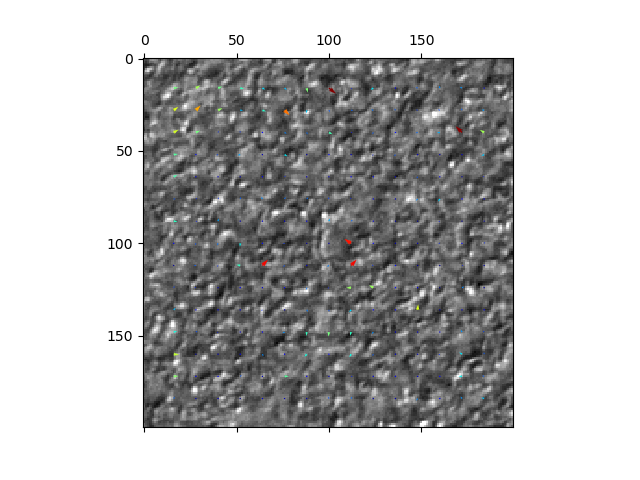

Shape of u3 is:  (15, 15)


In [23]:
################################################################################################
# Now we run that code. 
# We try it just on one frame (index is the index of the selected set of frames to look at).
#    So the actual frame is 'start+index' (remember setting 'start' and 'end' above?)
# 'step' is the interval between frames. Here it is set to 2. So we look at frame x and frame
#    x+2 and see how things have shifted.
###############################################################################################
mask, rmask, rmask2, rad, com
plt.figure()
index=640
step = 10 
x,y,u3,v3,pvl, div, clm, clrms, clstd = generate_vector_field(index,index+step,im, just_mask, just_mask2, centers_of_mass,
                                                              clearaxes=False, tosave=False,
                                                              winsize=18, searchsize=24, overlap=12);
print("Shape of u3 is: ", u3.shape)

In [24]:
# If you forgot what we set 'start' and 'end' to, see here...

print("Start and end frames: %i,%i" % (start,end))

Start and end frames: 1,750


<IPython.core.display.Javascript object>


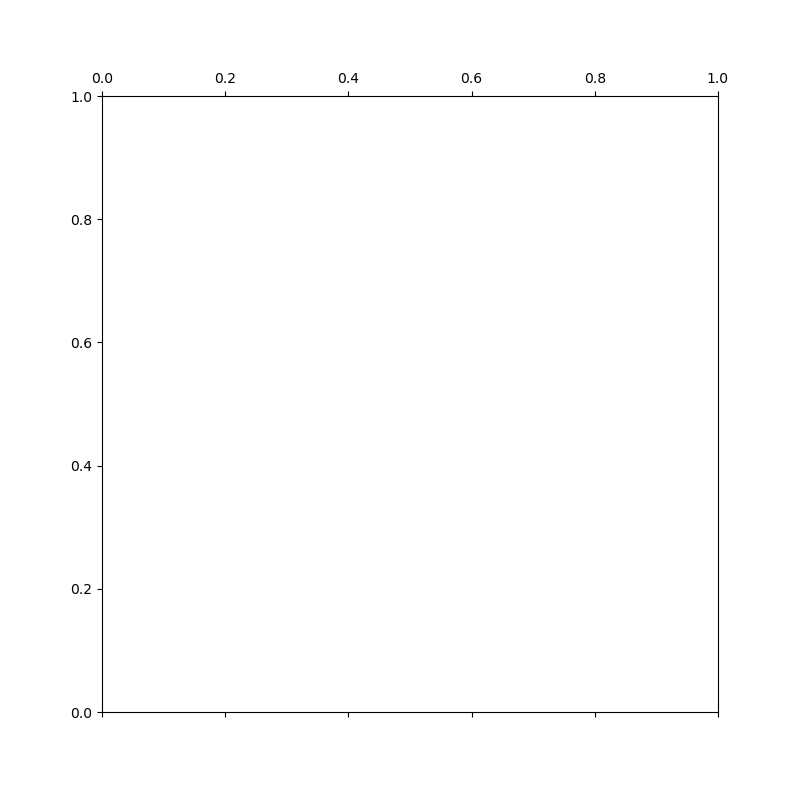

In [25]:
################################################################################################
# Now we run that code OVER ALL FRAMES FROM start TO end. 
#
# Here, we have 'step=1'
# and 'winsize=14, searchsize=20, overlap=10'
#
#
# You can try adjusting these.
###############################################################################################


step=20
indices = np.arange(0,end-start-step,1)
divs = np.zeros_like(indices)*1.0
clms = np.zeros_like(divs)
clrms = np.zeros_like(clms)
clstds = np.zeros_like(clms)

plt.figure(figsize=(8,8))
j=0
for i in indices:
    x,y,u3,v3,pvl, divs[j], clms[j], clrms[j], clstds[j] = generate_vector_field(i,i+step,im_matrix_new,just_mask, 
                                                                                 just_mask2, centers_of_mass,
                                                                                 tosave=False,
                                                                                 winsize=14, searchsize=20, overlap=10)
    j=j+1
    
    
#default: winsize=28, searchsize=36, overlap=22
#what has also worked (for step=2): winsize=18, searchsize=24, overlap=12

<IPython.core.display.Javascript object>


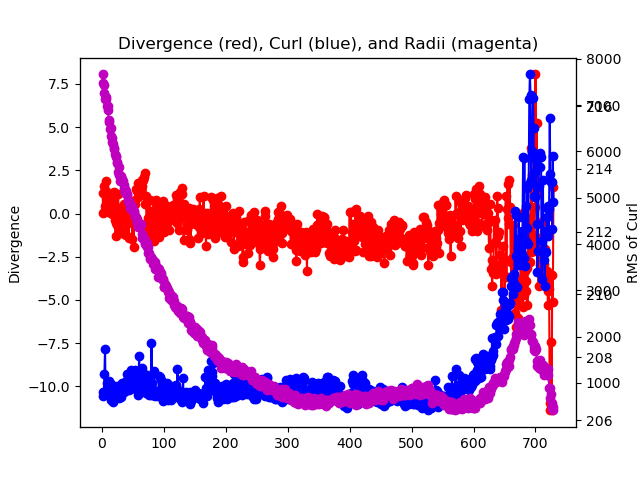

Text(0.5, 1.0, 'Divergence (red), Curl (blue), and Radii (magenta)')

In [26]:
#############################################################
# Here we plot the results!
#############################################################

fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax1.plot(frames[indices],divs,'-ro')
ax1.set_ylabel("Divergence")
ax2.plot(frames[indices],clrms,'-bo')
ax2.set_ylabel("RMS of Curl")
ax3.plot(frames[indices],radii[indices],'-mo')

plt.title("Divergence (red), Curl (blue), and Radii (magenta)")

<IPython.core.display.Javascript object>


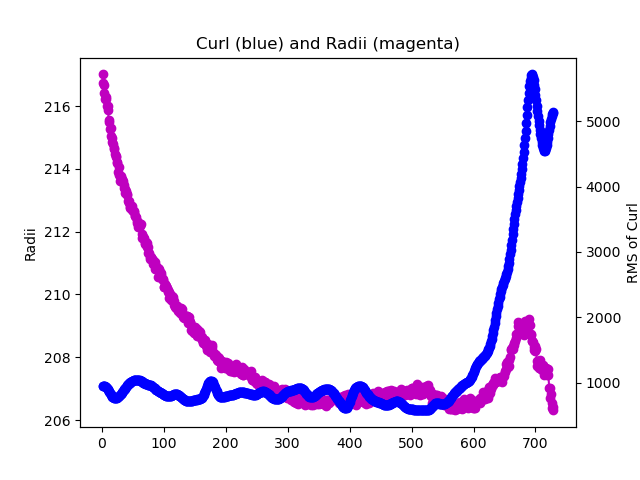

Text(0.5, 1.0, 'Curl (blue) and Radii (magenta)')

In [33]:
#############################################################
# Let's smooth the data. And not show the divergence.
#############################################################

fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
#ax3 = ax1.twinx()
ax2.plot(frames[indices],gf1d(clrms,6),'-bo')
ax2.set_ylabel("RMS of Curl")
#ax3.plot(frames[indices],gf1d(divs,15),'-ro')
#ax3.set_ylabel("Divergence")
ax1.plot(frames[indices],radii[indices],'-mo')
ax1.set_ylabel("Radii")

plt.title("Curl (blue) and Radii (magenta)")

<IPython.core.display.Javascript object>


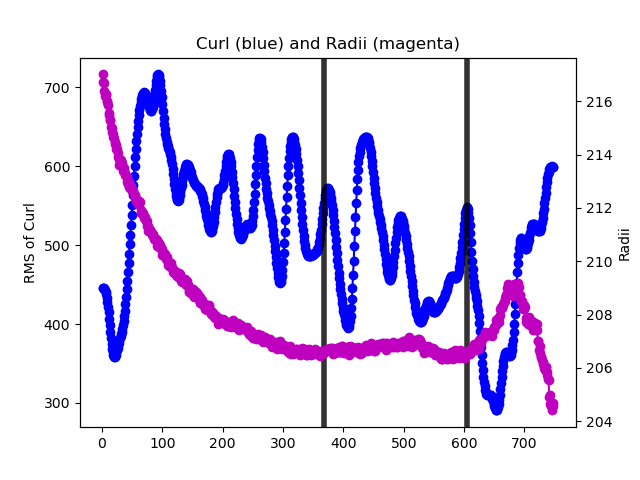

Text(0.5, 1.0, 'Curl (blue) and Radii (magenta)')

In [102]:
#############################################################
# Try to locate the "corners" of the curl
#############################################################

fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(frames[indices],gf1d(clrms,6),'-bo')
ax1.set_ylabel("RMS of Curl")
ax2.plot(frames[indices],radii[indices],'-mo')
ax2.set_ylabel("Radii")

ax1.axvline(368,c='k',lw=4,alpha=0.8)
ax1.axvline(604,c='k',lw=4,alpha=0.8)

plt.title("Curl (blue) and Radii (magenta)")